<h1><center> Домашняя работа #3</center></h1>

Задача:

- еализуйте алгоритм А2С (Advanced Actor Critic)
- обучите агента в среде Car Racing;

Описание задачи на сайте Gymnasium ([ссылка](https://gymnasium.farama.org/environments/box2d/lunar_lander/))

## Imports

In [1]:
1 + 1

2

In [2]:
!nvidia-smi

Mon Dec 15 19:39:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             33W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import sys

sys.path.append("..")

In [4]:
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from tqdm import trange
from torch import nn
from torch.nn import functional as F

from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import (
    DummyVecEnv,
    VecMonitor,
    VecFrameStack,
    VecTransposeImage,
)
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
# %pip install stable_baselines3

In [6]:
# %load_ext autoreload
# %autoreload 2

from src.torch_utils import (
    get_device,
    preprocess_state,
    transform_vector_state_to_tensor,
)
from src.actor_critic import (
    ActorNet,
    ValueNet,
    compute_returns,
)

In [7]:
# %load_ext tensorboard

## Environment

**Observation space:**

A top-down 96x96 RGB image of the car and race track.

**Actions:**

- 0: steering, -1 is full left, +1 is full right
- 1: gas
- 2: braking

The three numbers (in order) are:

1. Steering
   - Range: [-1.0, 1.0]
   - Negative values: turn left
   - Positive values: turn right
2. Acceleration (Gas)
   -  Range: [0.0, 1.0]
   - 0 = no acceleration
   - 1 = full acceleration
3. Brake
    -  Range: [0.0, 1.0]
   - 0 = no braking
   - 1 = full braking

---

Example Actions:

- [0.0, 0.5, 0.0] → Go straight, accelerate at 50% power, no brake.
- [-0.8, 0.1, 0.0] → Sharp left turn, low acceleration.
- [0.3, 0.0, 0.7] → Gentle right turn, no gas, brake at 70%.

**Rewards:**

The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.

In [8]:
# %pip install swig

In [9]:
# %pip install Box2D

---
## Версия в stable_baselines3

Мы используем CnnPolicy, так как нам нужна сверточная нейросеть для обработки изображения

In [10]:
device = get_device()

Используемое устройство: cuda


In [11]:
log_dir = "./a2c_log/"

In [12]:
env = make_vec_env(
    env_id="CarRacing-v3",
    n_envs=4,
    env_kwargs={"continuous": True, "max_episode_steps": 1_000},
    vec_env_cls=DummyVecEnv,
    monitor_dir=log_dir,
)

<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to 

In [13]:
env = VecMonitor(env)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


In [14]:
model = A2C(
    policy="CnnPolicy",
    n_steps=256,
    gamma=0.99,
    learning_rate=3e-4,  # as in the original paper
    max_grad_norm=0.5,
    use_rms_prop=True,
    vf_coef=0.25,
    ent_coef=0.01,
    gae_lambda=0.95,
    normalize_advantage=True,
    tensorboard_log=None,
    env=env,
    verbose=1,
    device=device,
)

Using cuda device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
model.learn(
    # ~n_episodes * envs * n_steps
    total_timesteps=150_000,
    progress_bar=True,
)

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 990       |
|    ep_rew_mean        | -64.9     |
| time/                 |           |
|    fps                | 86        |
|    iterations         | 100       |
|    time_elapsed       | 1177      |
|    total_timesteps    | 102400    |
| train/                |           |
|    entropy_loss       | -4.27     |
|    explained_variance | 0.675     |
|    learning_rate      | 0.0003    |
|    n_updates          | 99        |
|    policy_loss        | -0.000379 |
|    std                | 1         |
|    value_loss         | 2.41      |
-------------------------------------


In [17]:
df = load_results(log_dir)
timestamps, rewards = ts2xy(df, "timesteps")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
average_rewards = pd.Series(rewards).rolling(window=100).mean()

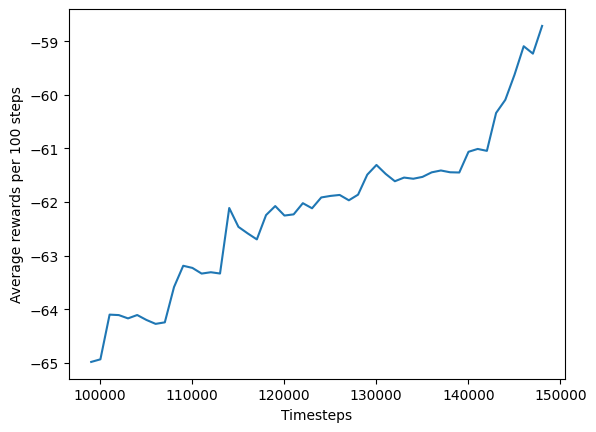

In [19]:
plt.plot(timestamps, average_rewards)
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.ylabel("Average rewards per 100 steps")
plt.show()

In [20]:
model.save("car_racing_stable_baseline")

In [ ]:
# model = A2C.load("car_racing_baseline")

In [ ]:
# def create_agent_env():
#     def _init():
#         env = gym.make(
#             "CarRacing-v3",
#             continuous=True,
#             domain_randomize=False,
#             lap_complete_percent=0.95,
#             max_episode_steps=5_000,
#             render_mode="rgb_array",
#         )
#         return env
#     env = DummyVecEnv([_init])
#     env = VecFrameStack(env, n_stack=4)
#     env = VecTransposeImage(env)
#     return env

In [ ]:
# agent_env = create_agent_env()
# render_env = gym.make(
#     "CarRacing-v3",
#     continuous=True,
#     domain_randomize=False,
#     lap_complete_percent=0.95,
#     max_episode_steps=5_000,
#     render_mode="human",
# )

In [ ]:
# obs_agent = agent_env.reset()
# obs_render, _ = render_env.reset()

# done = False
# score = 0

# while not done:
#     action, _ = model.predict(obs_agent, deterministic=True)
#     obs_agent, reward, done, _ = agent_env.step(action)
#     _, _, _,_, _ = render_env.step(action[0])
#     score += reward[0]

In [ ]:
# agent_env.close()
# render_env.close()

---
## Свой класс

## Реализация:
1. Инициализируем случайным образом сети политики (actor) $\pi^{\mu}(a|s)|_{\theta^{\mu}}$ и V-функции (critic) $V^{\theta}(s)|_{\theta^{V}}$ с весами $\theta^V$ и $\theta^{\mu}$ и целевые сети $V'$ и $\pi'$: $\theta^{V'} \gets \theta^V$ и $\theta^{\mu'} \gets \theta^{\mu}$
2. Устанавливаем число эпизодов обучения $M$ и для каждого эпизода выполняем:
3. Проходим траекторию, пока не достигнем конечного состояния.
    - Находясь в состоянии $s_t$ действуем в силу текущей политики и выбираем действие $a_t = \pi^{\mu}(s_t)|_{\theta^{\mu}}$
    - Выполняем действие $a_t$ и переходим в состояние $s_{t+1}$ и получаем награду $r_t$
    - В состоянии $s_{t+1}$ действуя в силу текущей политики выбираем действие $a_{t+1} = \pi^{\mu}(s_{t+1})|_{\theta^{\mu}}$
    - Вычисляем $Loss(\theta^V)=\big( r_t + \gamma V^{\theta}(s_{t+1}) - V^{\theta}(s_t) \big)^2$
    - Вычисляем $Loss(\theta^{\mu}) = \ln{\pi^{\mu}(a_t|s_t)}(r_t + \gamma V^{\theta}(s_{t+1}) - V^{\theta}(s_t))$
    - Обновляем веса: </br>
    __Внимание!__ У V-функции мы ___минимизируем___ веса, а в политике ___максимизируем_!__ </br>
      $\quad \quad \theta^V \gets \theta^V - \alpha \nabla_{\theta^V}Loss(\theta^V)$, </br>
      $\quad \quad \theta^{\mu} \gets \theta^{\mu} + \beta \nabla_{\theta^{\mu}}Loss(\theta^{\mu})$
    - Обновляем целевые сети: </br>
    $\quad \quad \theta^{V'} \gets \tau \theta^V + (1 - \tau) \theta^{V'}$, </br>
    $\quad \quad \theta^{\mu'} \gets \tau \theta^{\mu} + (1 - \tau) \theta^{\mu'}$

In [8]:
device = get_device()

Используемое устройство: cuda


In [22]:
# Основные параметры RL
gamma = torch.tensor(0.99).to(device)  # discount_factor
num_episodes = 150
entropy_coef = 0.01

# Основные параметры DL
lr = 3e-4  # as in the original paper
max_grad_norm = 0.5

In [23]:
# Используем параллельные/векторные среды для стабильности
env = gym.make_vec(
    "CarRacing-v3",
    num_envs=4,
    vectorization_mode="sync",
    continuous=True,
    max_episode_steps=1_000,
    wrappers=(lambda env: gym.wrappers.FrameStackObservation(env, 4),),
)

In [24]:
actor_model = ActorNet().to(device)
value_model = ValueNet().to(device)

In [25]:
# actor_model.apply(init_weights)
# value_model.apply(init_weights)

In [26]:
opt_actor = torch.optim.AdamW(actor_model.parameters(), lr=lr, fused=True)
opt_value = torch.optim.AdamW(value_model.parameters(), lr=lr, fused=True)

In [27]:
reward_records = []

for episode in trange(num_episodes):

    done = [False] * 4
    visited_states = []
    terminated_flags = []
    actions = []
    rewards = []
    state, _ = env.reset()

    # Play one episode (collect trajectory)
    while not all(done):

        state = preprocess_state(state)
        state = transform_vector_state_to_tensor(state, device=device)
        visited_states.append(state.squeeze(0))

        with torch.no_grad():
            raw_actions, transformed_actions = actor_model.get_actions(state)

        state, reward, terminated, truncated, _ = env.step(
            transformed_actions.cpu().numpy()
        )

        done = terminated | truncated
        terminated_flags.append(done)
        actions.append(raw_actions)
        rewards.append(reward)

    # Prepare data
    rewards_tensor = torch.tensor(rewards, device=device)
    terminated_tensor = torch.tensor(terminated_flags, device=device)

    # Train value model
    opt_value.zero_grad()

    values = value_model(torch.cat(visited_states))
    values = values.squeeze()

    returns = compute_returns(
        rewards=rewards_tensor,
        terminated=(~terminated_tensor).to(torch.float32),
        values=values,
        gamma=gamma,
        device=device,
    )
    returns = returns.flatten().to(torch.float32)
    advantages = (returns - values).detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    value_model_loss = F.mse_loss(values, returns)
    value_model_loss.backward()

    nn.utils.clip_grad_norm_(value_model.parameters(), max_grad_norm)
    opt_value.step()

    # Train actor model
    opt_actor.zero_grad()

    log_probs_tensor = actor_model.get_log_prob_given_actions(
        state=torch.cat(visited_states), raw_actions=torch.cat(actions)
    )
    # log_probs_tensor = torch.cat(log_probs)
    entropy = -log_probs_tensor.mean()
    policy_loss = -(log_probs_tensor * advantages).mean() - entropy_coef * entropy
    policy_loss.backward()

    nn.utils.clip_grad_norm_(actor_model.parameters(), max_grad_norm)
    opt_actor.step()

    reward_records.append(sum(rewards))

    if episode % 10 == 0:
        print(f"Mean for last 10 episodes is {np.mean(reward_records[-5:])}")

    # Stop if mean reward for 100 episodes > 475.0
    # Naive early stopping
    if np.average(reward_records[-100:]) > 475.0:
        break

print(f"\nDone in {episode+1} episodes")
env.close()

  1%|          | 1/150 [00:42<1:46:38, 42.94s/it]

Mean for last 10 episodes is -28.59503292772775


  7%|▋         | 11/150 [07:40<1:35:36, 41.27s/it]

Mean for last 10 episodes is -27.56684227244139


 14%|█▍        | 21/150 [14:32<1:28:45, 41.28s/it]

Mean for last 10 episodes is -28.427146291770516


 21%|██        | 31/150 [21:22<1:20:41, 40.68s/it]

Mean for last 10 episodes is -24.980349384429992


 27%|██▋       | 41/150 [28:13<1:15:10, 41.38s/it]

Mean for last 10 episodes is -26.122269721854956


 34%|███▍      | 51/150 [35:02<1:07:17, 40.79s/it]

Mean for last 10 episodes is -26.59916926565763


 41%|████      | 61/150 [41:48<59:33, 40.15s/it]  

Mean for last 10 episodes is -24.50925602760068


 47%|████▋     | 71/150 [48:33<52:47, 40.09s/it]

Mean for last 10 episodes is -26.242550937007167


 54%|█████▍    | 81/150 [55:17<46:02, 40.04s/it]

Mean for last 10 episodes is -25.749459450762952


 61%|██████    | 91/150 [1:02:03<39:55, 40.61s/it]

Mean for last 10 episodes is -25.486110721505973


 67%|██████▋   | 101/150 [1:08:50<33:08, 40.59s/it]

Mean for last 10 episodes is -27.319129126250736


 74%|███████▍  | 111/150 [1:15:34<26:12, 40.32s/it]

Mean for last 10 episodes is -28.115793203900115


 81%|████████  | 121/150 [1:22:14<19:28, 40.28s/it]

Mean for last 10 episodes is -27.051176624962125


 87%|████████▋ | 131/150 [1:29:01<13:00, 41.06s/it]

Mean for last 10 episodes is -26.42861373137856


 94%|█████████▍| 141/150 [1:35:48<06:06, 40.70s/it]

Mean for last 10 episodes is -27.641163737983806


100%|██████████| 150/150 [1:41:55<00:00, 40.77s/it]


Done in 150 episodes


## Training graphs

In [32]:
reward_records_avg = [np.mean(x) for x in reward_records]

In [33]:
table = pd.DataFrame(reward_records_avg, columns=["reward"])

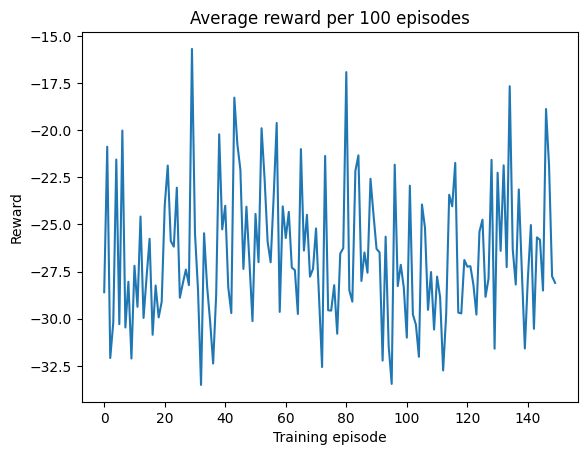

In [34]:
plt.plot(table.index, table["reward"])
plt.xlabel("Training episode")
plt.ylabel("Reward")
plt.title("Average reward per 100 episodes")
plt.show()

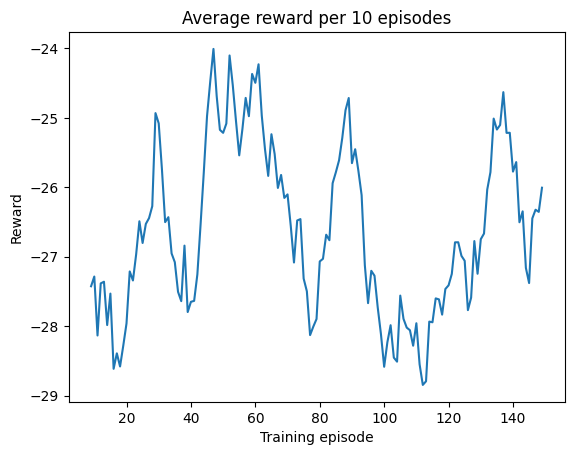

In [35]:
plt.plot(table.index, table["reward"].rolling(10).mean())
plt.xlabel("Training episode")
plt.ylabel("Reward")
plt.title("Average reward per 10 episodes")
plt.show()

## Анимация

In [ ]:
# Раскомментируйте, чтобы увидеть игру
# env = gym.make(
#     "CarRacing-v3",
#     continuous=True,
#     render_mode="human",
# )

In [ ]:
# env = gym.wrappers.FrameStackObservation(env, 4)

In [ ]:
# device = get_device()

# done = False
# state, _ = env.reset()

# while not done:
#     env.render()
#     state = preprocess_state(state)
#     state = transform_state_to_tensor(state, device=device)
#     with torch.no_grad():
#         _, transformed_actions = actor_model.get_actions(state)

#     state, reward, terminated, truncated, _ = env.step(
#         transformed_actions.cpu().numpy().flatten()
#     )

#     done = terminated or truncated

# env.close()

# print(f"Score is: {score}")

In [ ]:
# env.close()